In [1]:
import tensorflow as tf
from IPython.display import clear_output
tf.keras.utils.set_random_seed(42)
import skdim
import time
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import f1_score
import math
import matplotlib.pyplot as plt
from sklearn import datasets, manifold

### Import data and obtain the number of labels:

In [2]:
filename = 'data/dataset3.pkl'

with open(filename, 'rb') as f:
    data_tuples = pickle.load(f)
f.close()

In [3]:
print('Number of Data Points:', len(data_tuples))
class_labels = []
for i in range(len(data_tuples)):
    class_labels.append(data_tuples[i][1])

print('Class Labels:', len(set(class_labels)))
print('Feature Count:', len(data_tuples[0][0]))

Number of Data Points: 2500
Class Labels: 5
Feature Count: 175


### Perform Estimation

In [4]:
data = pd.DataFrame([i[0] for i in data_tuples])
data = (data - np.min(data)) / (np.max(data) - np.min(data))
labels = pd.DataFrame([i[1] for i in data_tuples])

In [6]:
data_0 = [i[0] for i in data_tuples if i[1] == 0]
data_1 = [i[0] for i in data_tuples if i[1] == 1]
data_2 = [i[0] for i in data_tuples if i[1] == 2]
data_3 = [i[0] for i in data_tuples if i[1] == 3]
data_4 = [i[0] for i in data_tuples if i[1] == 4]

In [7]:
for i, d in enumerate([data_0, data_1, data_2, data_3, data_4]):

    #estimate global intrinsic dimension:
    est = skdim.id.lPCA().fit(d)

    print("[{}] lPCA (PFO):".format(i), np.mean(est.dimension_))

    #estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
    est = skdim.id.MOM().fit(d, n_neighbors = round(math.sqrt(len(data_tuples))), n_jobs = -1,)

    print("[{}] MOM:".format(i), np.mean(est.dimension_pw_))

[0] lPCA (PFO): 110.0
[0] MOM: 34.930918848346906
[1] lPCA (PFO): 110.0
[1] MOM: 35.07259944950361
[2] lPCA (PFO): 110.0
[2] MOM: 33.90669585450881
[3] lPCA (PFO): 110.0
[3] MOM: 35.17522565292993
[4] lPCA (PFO): 110.0
[4] MOM: 34.24965371509311


### Visualize Data ###

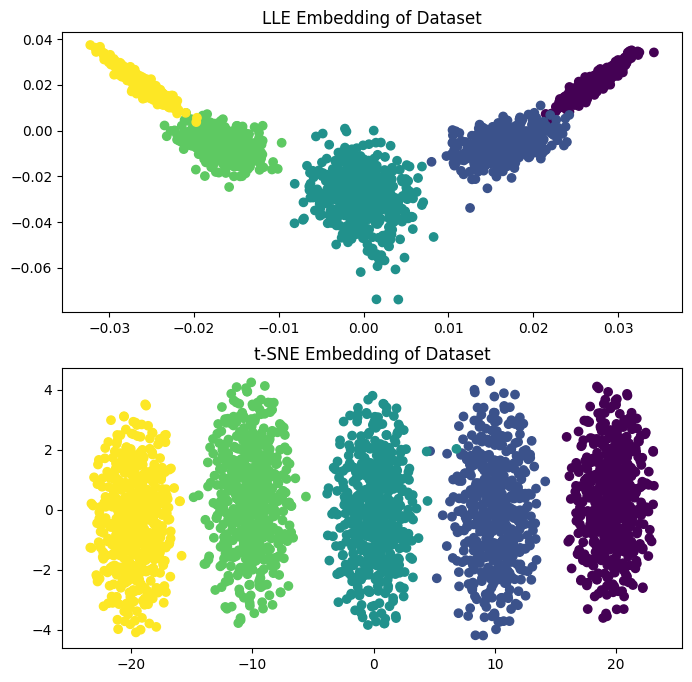

In [8]:
n_neighbors = round(math.sqrt(len(data_tuples)))

sr_lle, sr_err = manifold.locally_linear_embedding(
    data, n_neighbors=n_neighbors, n_components=2
)

sr_tsne = manifold.TSNE(n_components=2, perplexity=n_neighbors, random_state=0).fit_transform(
    data
)

fig, axs = plt.subplots(figsize=(8, 8), nrows=2)
axs[0].scatter(sr_lle[:, 0], sr_lle[:, 1], c=labels)
axs[0].set_title("LLE Embedding of Dataset")
axs[1].scatter(sr_tsne[:, 0], sr_tsne[:, 1], c=labels)
_ = axs[1].set_title("t-SNE Embedding of Dataset")

### Classifier ###

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)

ID = 110
shape = len(data_tuples[0][0]) # feature count

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(shape,)),
    tf.keras.layers.Dense(ID, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

start_time = time.time()

model.fit(X_train, y_train, epochs=50)

clear_output(wait=True)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.8696398735046387 seconds ---


In [19]:
test_loss, test_acc = model.evaluate(X_test,  y_test)
f1 = f1_score(y_test, [0 if x < 0 else 1 for x in model.predict(X_test)], average='weighted')

print('\nTest accuracy:', test_acc)
print('\nTest F1 (weighted):', f1)

16/16 [==============================] - 0s 421us/step

Test accuracy: 0.20000000298023224

Test F1 (weighted): 0.06666666666666667


### Analyze Model Weights ###

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 110)               19360     
                                                                 
 dense_5 (Dense)             (None, 1)                 111       
                                                                 
Total params: 19471 (76.06 KB)
Trainable params: 19471 (76.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
unused_threshold = 0.005   # used to determine if a weight is being 'unused' 

for layer in model.layers:
    
    weights = layer.get_weights()
    print("Layer Name:", layer.name)
    print("Weight #:", len(weights[0]))
    
    sorted_weights = [i[0] for i in weights[0]]
    #print("Sorted Weights:", np.sort(sorted_weights))
    
    print("'Unused Weights:'", sum(1 for i in np.sort(sorted_weights) if abs(i) <= 0.005))

Layer Name: dense_4
Weight #: 175
'Unused Weights:' 0
Layer Name: dense_5
Weight #: 110
'Unused Weights:' 4
